In [1]:
import numpy as np
import pandas as pd
import os
import pymongo

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
train_on_gpu = torch.cuda.is_available()
from sklearn.decomposition import PCA
from sklearn import preprocessing
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available.')

CUDA is available.


In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
sns.set_style('whitegrid')
from os import listdir
from os.path import isfile, join
from pandas_datareader import data
import yfinance as yf
import math
import pmdarima as pm

In [125]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.base import clone
import shap

In [4]:
AAPL_df = pd.read_csv('collected_df.csv')
AAPL_df = pd.read_csv('collected_df.csv', index_col = [0])
AAPL_cols = AAPL_df.columns.tolist()
AAPL_cols.remove('Close')
AAPL_cols = ['Close'] + AAPL_cols
AAPL_df = AAPL_df[AAPL_cols]
# AAPL_df = AAPL_df[['Date', 'Close']]
AAPL_df

,Close,Date,Volume,Adj Close,^DJI_Close,^IXIC_Close,^GSPC_Close,^RLG_Close,^NYA_Close,^VIX_Close,...,BACTSAMFRBDAL,IR,IQ,PPIACO,CPIAUCSL,CPILFESL,MICH,CSCICP03USM665S,Grow,News_Score
0,27.332500,2015-01-02,212818400,24.565697,17832.990234,4726.810059,2058.199951,960.280029,10830.919922,17.790001,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,False,0.500000
1,26.562500,2015-01-05,257142000,23.873644,17501.650391,4652.569824,2020.579956,943.780029,10607.679688,19.920000,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,False,0.500375
2,26.565001,2015-01-06,263188400,23.875887,17371.640625,4592.740234,2002.609985,935.020020,10514.870117,21.120001,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,True,0.719541
3,26.937500,2015-01-07,160423600,24.210682,17584.519531,4650.470215,2025.900024,946.880005,10627.129883,19.309999,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,True,0.074792
4,27.972500,2015-01-08,237458000,25.140909,17907.869141,4736.189941,2062.139893,964.159973,10800.540039,17.010000,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,True,0.996247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,131.860001,2022-12-23,63814900,131.658981,33203.929688,10497.860352,3844.820068,2165.620117,15188.450195,20.870001,...,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411,False,0.696560
2003,130.029999,2022-12-27,69007800,129.831772,33241.558594,10353.230469,3829.250000,2144.899902,15218.259766,21.650000,...,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411,False,0.312938
2004,126.040001,2022-12-28,85438400,125.847855,32875.710938,10213.290039,3783.219971,2117.199951,15037.320312,22.139999,...,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411,False,0.175638
2005,129.610001,2022-12-29,75703700,129.412415,33220.800781,10478.089844,3849.280029,2163.790039,15241.209961,21.440001,...,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411,True,0.930547


In [128]:
from sklearn.preprocessing import MinMaxScaler


def data_normalisation(df):
    scaler=MinMaxScaler(feature_range=(0,1))
    
    for column_name in list(df.columns.values):
        if column_name == 'Date':
            continue
        the_list = df[column_name].tolist()
        the_list = np.array(the_list)
        the_list = scaler.fit_transform(the_list.reshape(-1,1))
        df.drop(column_name, axis = 1, inplace = True)
        df[column_name] = the_list
    return df,scaler
        
def split_train_test_data(df, lookback, pred_length=1, use_PCA= False):
    df_list = df.loc[:, df.columns != 'Date'].values.tolist()
    
    res_list = df['Close'].tolist()
    res_list = np.array(res_list)
    print(len(res_list))
    data = []
    res_data = []
    
    num_feature = len(df.columns.tolist())
    if use_PCA:
        pca_fit = PCA(num_feature-1)
        df_list = pca_fit.fit_transform(df_list)
        df_list=scaler.fit_transform(df_list)
       

    for index in range(len(df_list) - lookback - pred_length + 1): 
        the_list = df_list[index: index + lookback]
        the_list= np.array(the_list)
        the_list = the_list.reshape(-1)
#         the_list= np.transpose(the_list)
        if index==0:
            print(the_list)
        data.append(the_list)
        res_data.append(res_list[index + lookback:index + lookback + pred_length])

    data = np.array(data)
    res_data = np.array(res_data)
    
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)*2
    
    x_train = data[:train_set_size]
    y_train = res_data[:train_set_size]
    y_train = np.squeeze(y_train)
    
    x_val = data[train_set_size:train_set_size+test_set_size]
    y_val = res_data[train_set_size:train_set_size+test_set_size]
    y_val = np.squeeze(y_val)
    
    x_test = data[train_set_size+test_set_size:]
    y_test = res_data[train_set_size+test_set_size:]
    y_test = np.squeeze(y_test)
    
    return x_train, y_train,x_val,y_val, x_test, y_test

In [129]:
def combine_values(the_list,last=True):
    res=[]
    for i in range(len(the_list)):
        if last:
            if i==len(the_list)-1:
                for ii in range(len(the_list[i])):
                    res.append(the_list[i][ii])
            else:
                res.append(the_list[i][0])
        else:
            res.append(the_list[i][0])
    res=np.array(res)
    return res

In [130]:
def forecast_accuracy(forecast, actual):
    print(forecast.shape)
#     print(forecast[0], actual[0])
    ae = np.sum(np.abs(forecast - actual))    # AE
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'ae':ae, 'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
#             'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

def denormalise(the_df,thevalue):
    themax=the_df['Close'].max()
    themin=the_df['Close'].min()
    therange = themax - themin
    thevalue = thevalue*therange+themin
#     print(thevalue)
    return thevalue

In [131]:
def evaluate(pred_train, y_train, pred_val, y_val, pred_test, y_test, the_df, lookback, pred_length, is_stock =  True):
    actual_values = np.concatenate((y_train,  y_val), axis=0)[:,0]
    actual_values = np.concatenate((actual_values,y_test[:,0]), axis=0)
    actual_values = denormalise(the_df,actual_values)
    print(actual_values.shape)
    actual = actual_values
    
    predict = np.copy(pred_train[:,0])
    val_predict = np.copy(pred_val[:,0])
    test_predict = np.copy(pred_test[:,0])
    predict = denormalise(the_df,predict)
    val_predict = denormalise(the_df,val_predict)
    test_predict = denormalise(the_df,test_predict)
    print('predict',predict.shape)   
    train_num = len(predict)
    train_sum = 0 
    for i in range(train_num):
        train_sum += np.abs(actual_values[i]-predict[i])
    print('Train Loss:',train_sum.sum()/train_num)
    

    val_num = len(val_predict)
    val_sum = 0 
    for i in range(val_num):
        val_sum += np.abs(actual_values[train_num+i]-val_predict[i])
    print('Val Loss:',val_sum.sum()/val_num)

    test_num = len(test_predict)
    test_sum = 0 
    for i in range(test_num):
        test_sum += np.abs(actual_values[val_num+train_num+i]-test_predict[i])
    print('Test Loss:',test_sum.sum()/test_num)
#     predict=combine_values(predict,True)
    print('predict',predict.shape)
#     val_predict=combine_values(val_predict,True)
    print('val_predict',val_predict.shape)
    
#     val_predict = np.append(val_predict,test_predict[0])
#     print(len(val_predict))
    os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
    
    print('test_predict',test_predict.shape)
    the_df['Date'] = pd.to_datetime(the_df['Date'], format='%Y-%m-%d')

    data_date = the_df['Date'].tolist()
    data_date = np.array(data_date[lookback:-pred_length+1])
        # data_len = len(data_date)
    fig = figure(figsize=(25, 5), dpi=300)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, actual, label="Actual Prices", color='b')
    plt.plot(data_date[:len(predict)], predict, label="Predicted Training Prices", color='r')
    plt.plot(data_date[len(predict):len(predict)+len(val_predict)], val_predict, label="Predicted Validation Prices", color='g')
    plt.plot(data_date[len(predict)+len(val_predict):], test_predict, label="Predicted Testing Prices", color='k')
    plt.title("Predicted Close Prices and Actual Close Prices")

    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.savefig('Data_Pred.png')
    plt.show()

    print(len(actual_values[:train_num]),len(actual_values[train_num:val_num+train_num]),len(actual_values[val_num+train_num:]))
    print(len(predict),len(val_predict),len(test_predict))
    print(len(x_val))

    print(forecast_accuracy(pred_train, y_train))
    print(forecast_accuracy(pred_val, y_val))
    print(forecast_accuracy(pred_test, y_test))


In [119]:
lookback = 15 # choose sequence length
pred_length = 15
normalised_AAPL_df,scaler = data_normalisation(AAPL_df.copy())
x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback, pred_length)# change the num_feature value for using more features

2007
[0.0297789  0.28946222 0.02304532 0.10278454 0.0390116  0.07721029
 0.03296827 0.23944136 0.11760707 0.09757073 0.85565484 0.94078641
 0.13510538 0.2264055  0.55984628 0.         0.         0.
 0.         0.08963356 0.42032773 0.04252972 0.89438758 0.93579767
 0.         0.91113392 0.69756554 0.74834983 0.62611012 0.28115016
 0.16460905 0.10813433 0.         0.         0.12121212 0.91089716
 0.         0.50058757 0.02494904 0.3616941  0.0187146  0.08711055
 0.03271504 0.06453287 0.02556219 0.2134117  0.14656695 0.10932604
 0.80658491 0.88362576 0.15299289 0.25159944 0.54342034 0.14418058
 0.53602637 0.04790614 0.1029399  0.08963356 0.42032773 0.04252972
 0.89438758 0.93579767 0.         0.91113392 0.69756554 0.74834983
 0.62611012 0.28115016 0.16460905 0.10813433 0.         0.
 0.12121212 0.91089716 0.         0.50096331 0.02496473 0.37154761
 0.01872864 0.08096045 0.02764069 0.05847723 0.02163024 0.20259017
 0.1628824  0.11402834 0.80403938 0.87847077 0.16838214 0.27560441
 0.530

(1978,)
predict (1186,)
Train Loss: 0.32224371798009166
Val Loss: 18.078486145643343
Test Loss: 54.04562668657425
predict (1186,)
val_predict (396,)
test_predict (396,)


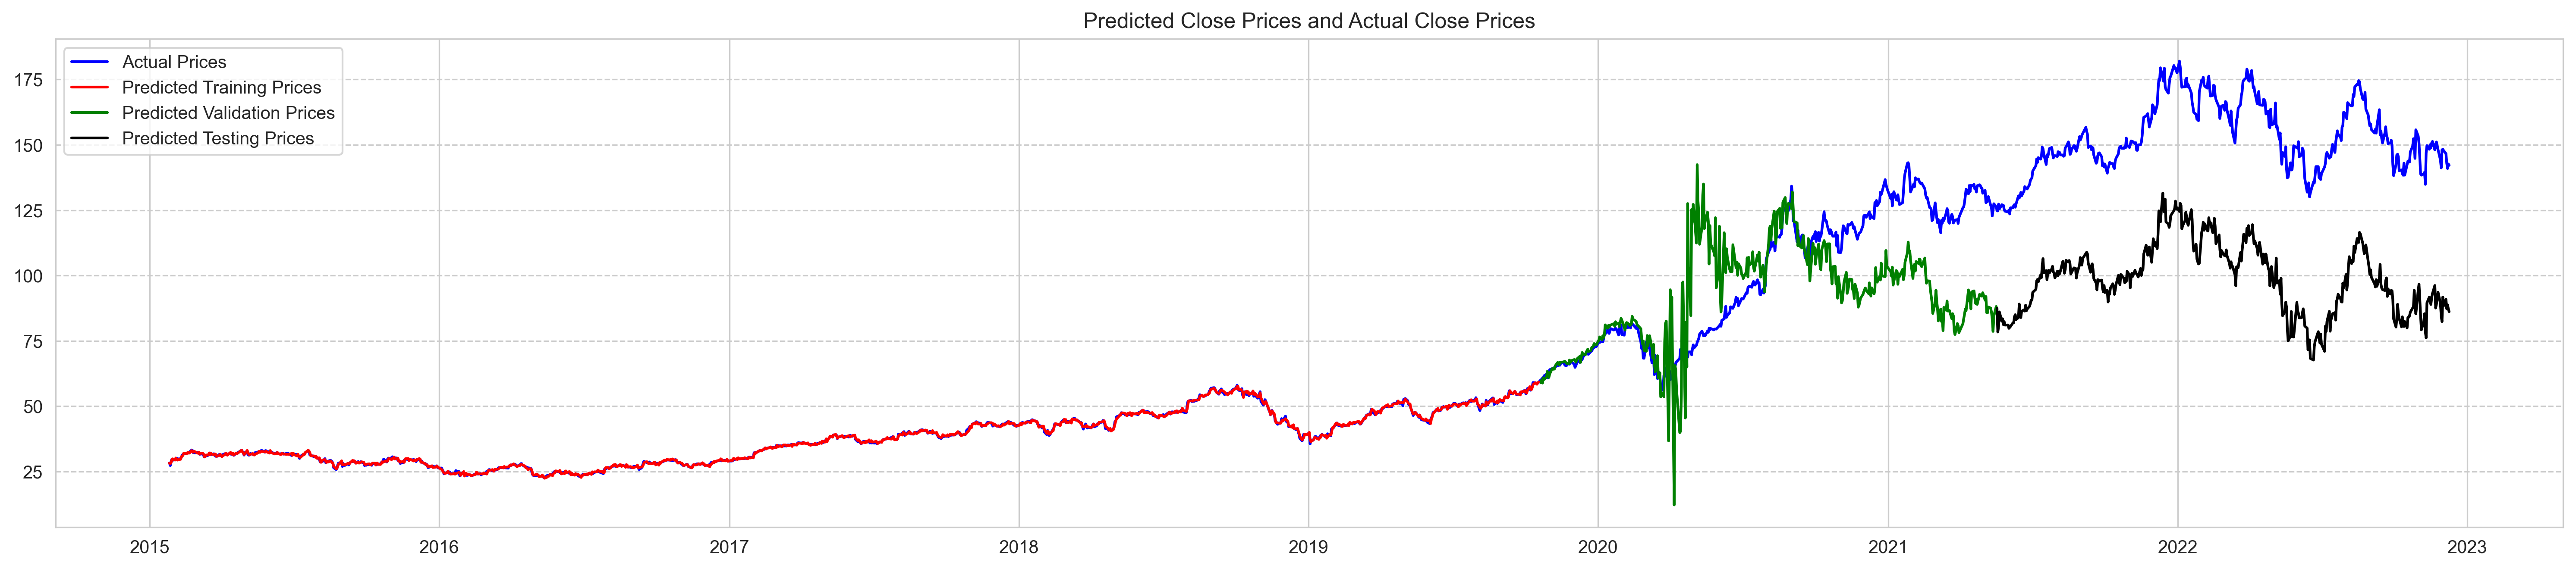

1186 396 396
1186 396 396
396
(1186, 15)
{'ae': 71.4434940498205, 'mape': inf, 'me': -2.579443123401871e-15, 'mae': 0.004015935584587999, 'mpe': inf, 'rmse': 0.005208066271816576, 'corr': 0.8528179270799989, 'minmax': 0.07753789280481427}
(396, 15)
{'ae': 5070.296824332764, 'mape': 1.505199634357329, 'me': -0.7953024708741119, 'mae': 0.8535853239617448, 'mpe': -1.3320721428624136, 'rmse': 1.1194158658803581, 'corr': 0.833084477816772, 'minmax': 1.4563084320402355}
(396, 15)
{'ae': 12142.683655874815, 'mape': 2.516950567372966, 'me': -2.0442228376893627, 'mae': 2.0442228376893627, 'mpe': -2.516950567372966, 'rmse': 2.152576867269029, 'corr': 0.9995604129930663, 'minmax': 2.516950567372966}


In [139]:
reg = LinearRegression()
reg_list = [clone(reg) for _ in range(pred_length)]
for i in range(pred_length):
    reg_list[i].fit(x_train, y_train[:,i])
train_predictions = []
val_predictions = []
test_predictions = []
for i in range(pred_length):
    train_predictions.append(reg_list[i].predict(x_train))
    val_predictions.append(reg_list[i].predict(x_val))
    test_predictions.append(reg_list[i].predict(x_test))
train_predictions = np.transpose(train_predictions)
val_predictions = np.transpose(val_predictions)
test_predictions = np.transpose(test_predictions)

evaluate(train_predictions, y_train, val_predictions, y_val, test_predictions, y_test, AAPL_df, lookback, pred_length)

In [140]:
train_predictions

array([[0.03542742, 0.02948666, 0.03934913, ..., 0.05386156, 0.05639634,
        0.05734202],
       [0.03389399, 0.0405383 , 0.04133608, ..., 0.05248917, 0.05301403,
        0.05253845],
       [0.03603914, 0.03898982, 0.04016407, ..., 0.05527518, 0.05472805,
        0.0545101 ],
       ...,
       [0.22459462, 0.22729102, 0.22943093, ..., 0.241099  , 0.24181671,
        0.2395578 ],
       [0.22850467, 0.23015458, 0.23367735, ..., 0.24104713, 0.23869501,
        0.24186011],
       [0.22969405, 0.23347737, 0.23145975, ..., 0.23861685, 0.24221834,
        0.24711246]])

(1186, 15)
(1978,)
(1186, 15)
predict (1186,)
Train Loss: 0.4736306655973037
Val Loss: 9.736909723596881
Test Loss: 16.888810106063648
predict (1186,)
val_predict (396,)
test_predict (396,)


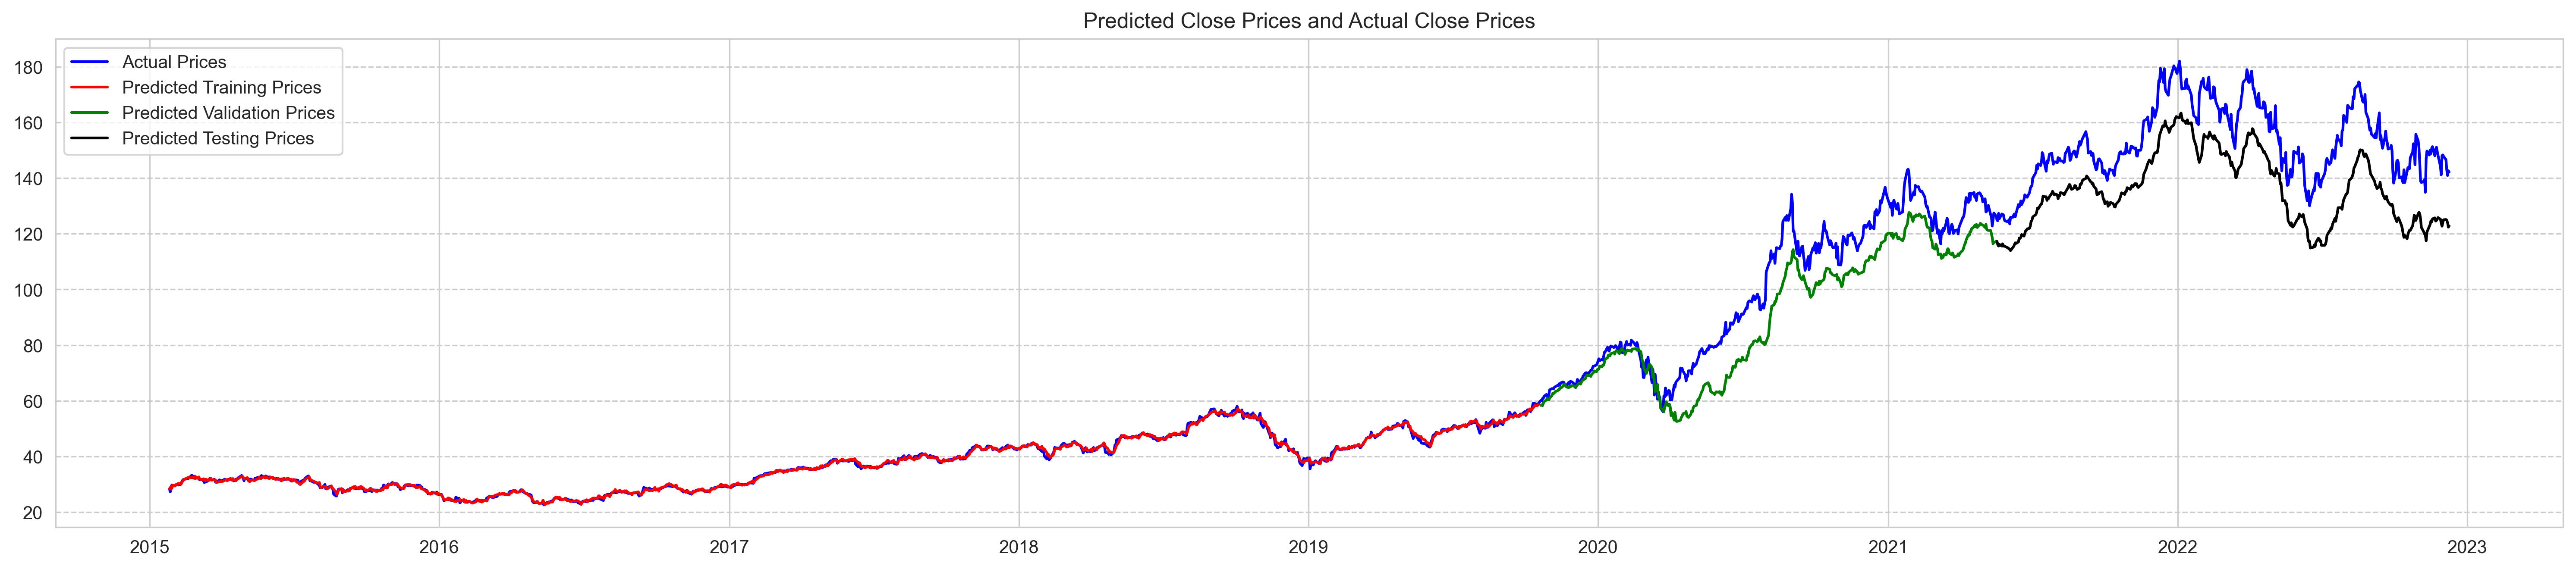

1186 396 396
1186 396 396
396
(1186, 15)
{'ae': 98.48526069657794, 'mape': inf, 'me': -6.485350012312887e-16, 'mae': 0.005535989921111745, 'mpe': inf, 'rmse': 0.007328683808369681, 'corr': 0.8607857790092781, 'minmax': 0.09312398988548376}
(396, 15)
{'ae': 1363.9131448557264, 'mape': 0.4422774024961983, 'me': -0.2280272908092518, 'mae': 0.2296150075514691, 'mpe': -0.4360087159240489, 'rmse': 0.2755498049642675, 'corr': 0.8732036137809986, 'minmax': 0.4418059099879773}
(396, 15)
{'ae': 2616.4753974063688, 'mape': 0.5398792203974848, 'me': -0.4404840736374358, 'mae': 0.4404840736374358, 'mpe': -0.5398792203974848, 'rmse': 0.4677194770812717, 'corr': 0.9996502783821646, 'minmax': 0.5398792203974847}


In [123]:
reg = RidgeCV()
reg_list = [clone(reg) for _ in range(pred_length)]
for i in range(pred_length):
    reg_list[i].fit(x_train, y_train[:,i])
train_predictions = []
val_predictions = []
test_predictions = []
for i in range(pred_length):
    train_predictions.append(reg_list[i].predict(x_train))
    val_predictions.append(reg_list[i].predict(x_val))
    test_predictions.append(reg_list[i].predict(x_test))
train_predictions = np.transpose(train_predictions)
val_predictions = np.transpose(val_predictions)
test_predictions = np.transpose(test_predictions)

evaluate(train_predictions, y_train, val_predictions, y_val, test_predictions, y_test, AAPL_df, lookback, pred_length)

(1186, 15)
(1978,)
(1186, 15)
predict (1186,)
Train Loss: 0.42319507328858086
Val Loss: 2.987370554654649
Test Loss: 4.278739060268736
predict (1186,)
val_predict (396,)
test_predict (396,)


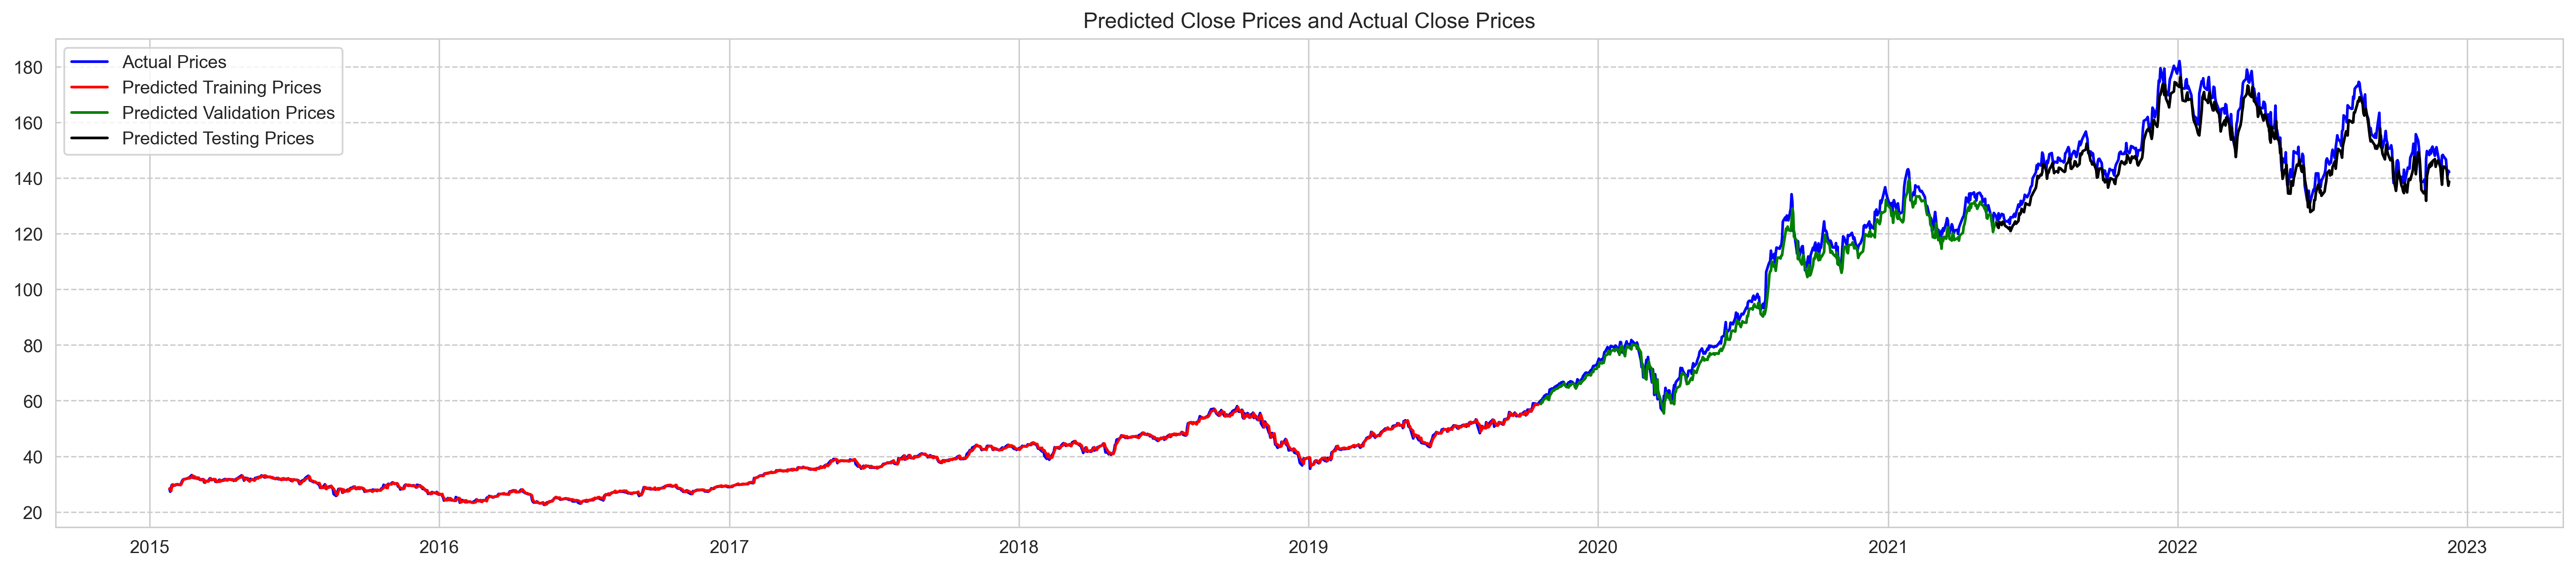

1186 396 396
1186 396 396
396
(1186, 15)
{'ae': 119.50944330711428, 'mape': inf, 'me': -1.1832393786898802e-17, 'mae': 0.006717787706976632, 'mpe': inf, 'rmse': 0.009447162974480987, 'corr': 0.9339018261992106, 'minmax': 0.10579564590888979}
(396, 15)
{'ae': 500.12556157725595, 'mape': 0.1691402634824368, 'me': -0.0821200371924507, 'mae': 0.08419622248775353, 'mpe': -0.16123125222274337, 'rmse': 0.10224953843248057, 'corr': 0.9740569294013757, 'minmax': 0.16864654954894098}
(396, 15)
{'ae': 747.3099296346869, 'mape': 0.15204271946594097, 'me': -0.12556135465299886, 'mae': 0.125809752463752, 'mpe': -0.1517092866645148, 'rmse': 0.14371362988673447, 'corr': 0.999714192339338, 'minmax': 0.15203865234402247}


In [126]:
reg = LassoCV()
reg_list = [clone(reg) for _ in range(pred_length)]
for i in range(pred_length):
    reg_list[i].fit(x_train, y_train[:,i])
train_predictions = []
val_predictions = []
test_predictions = []
for i in range(pred_length):
    train_predictions.append(reg_list[i].predict(x_train))
    val_predictions.append(reg_list[i].predict(x_val))
    test_predictions.append(reg_list[i].predict(x_test))
train_predictions = np.transpose(train_predictions)
val_predictions = np.transpose(val_predictions)
test_predictions = np.transpose(test_predictions)

evaluate(train_predictions, y_train, val_predictions, y_val, test_predictions, y_test, AAPL_df, lookback, pred_length)

(1978,)
predict (1186,)
Train Loss: 2.9021894556151593
Val Loss: 44.61590280279149
Test Loss: 58.45827843600777
predict (1186,)
val_predict (396,)
test_predict (396,)


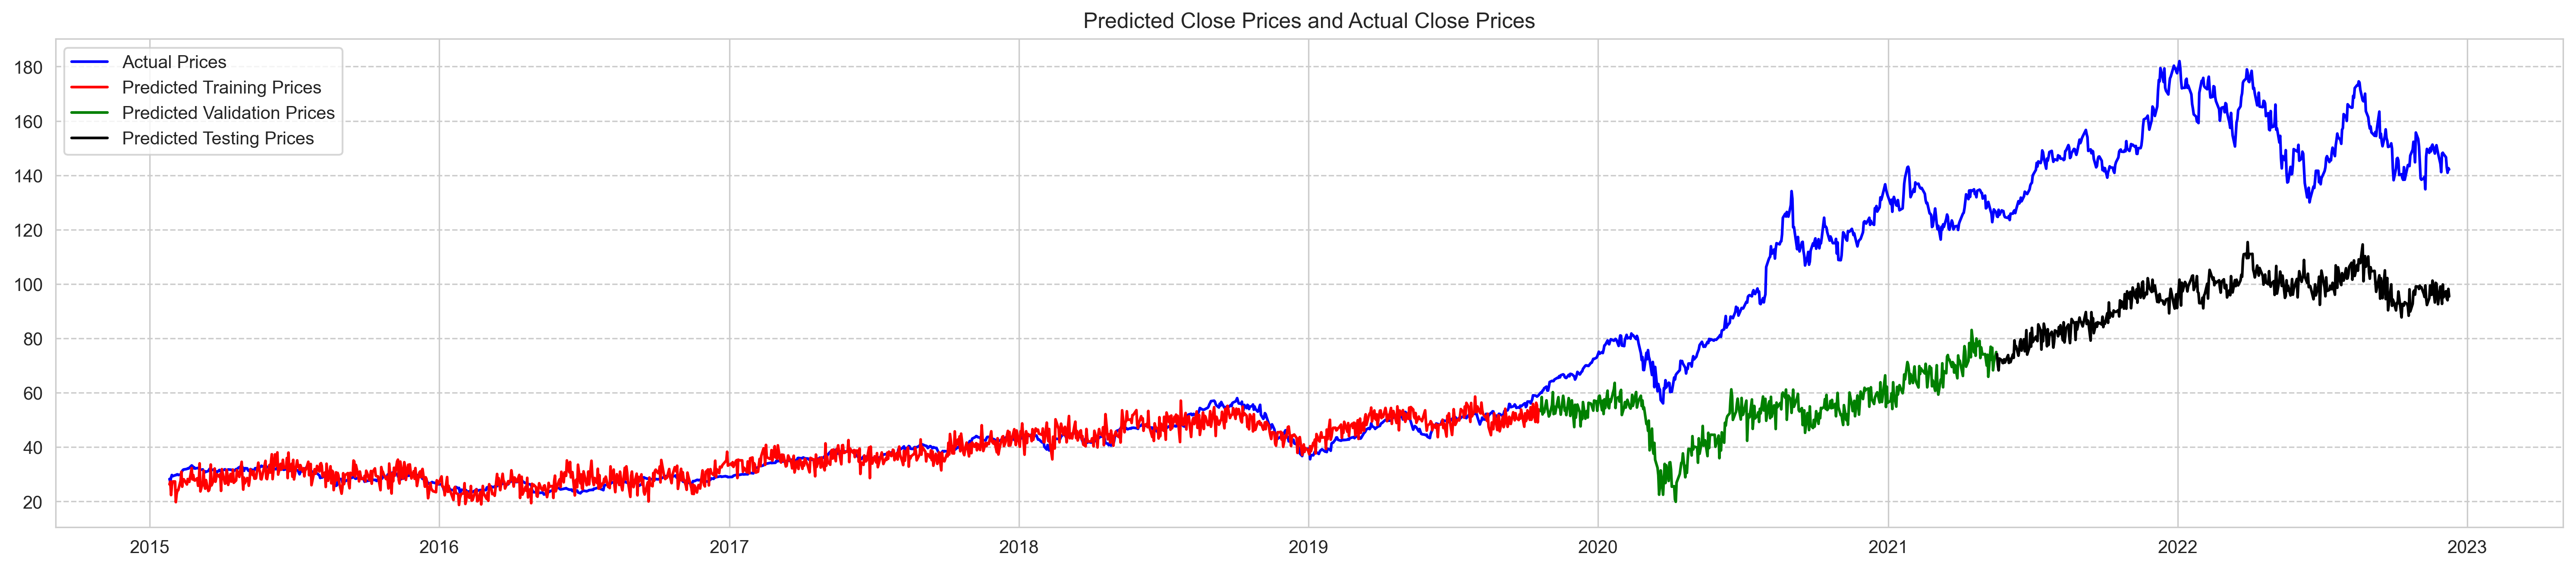

1186 396 396
1186 396 396
396
(1186, 15)
{'ae': 312.258986358821, 'mape': inf, 'me': -0.0007367232960603051, 'mae': 0.017552500638494718, 'mpe': nan, 'rmse': 0.022310748963812937, 'corr': 0.522835509050592, 'minmax': inf}
(396, 15)
{'ae': 1731.499512024775, 'mape': 0.569584411790948, 'me': -0.29125489108375485, 'mae': 0.2914982343476052, 'mpe': -0.5685506037314522, 'rmse': 0.3248721257659329, 'corr': 0.5869158660984304, 'minmax': 0.5694900974418005}
(396, 15)
{'ae': 2574.0121553712215, 'mape': 0.5273859454177092, 'me': -0.4333353796921248, 'mae': 0.4333353796921248, 'mpe': -0.5273859454177092, 'rmse': 0.4464791710992998, 'corr': 0.8725528285070482, 'minmax': 0.5273859454177092}


In [132]:
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor(hidden_layer_sizes=(128,128,))
reg_list = [clone(reg) for _ in range(pred_length)]
for i in range(pred_length):
    reg_list[i].fit(x_train, y_train[:,i])
train_predictions = []
val_predictions = []
test_predictions = []
for i in range(pred_length):
    train_predictions.append(reg_list[i].predict(x_train))
    val_predictions.append(reg_list[i].predict(x_val))
    test_predictions.append(reg_list[i].predict(x_test))
train_predictions = np.transpose(train_predictions)
val_predictions = np.transpose(val_predictions)
test_predictions = np.transpose(test_predictions)

evaluate(train_predictions, y_train, val_predictions, y_val, test_predictions, y_test, AAPL_df, lookback, pred_length)

(1978,)
predict (1186,)
Train Loss: 0.29984914328140244
Val Loss: 47.36518147675874
Test Loss: 102.34698528128996
predict (1186,)
val_predict (396,)
test_predict (396,)


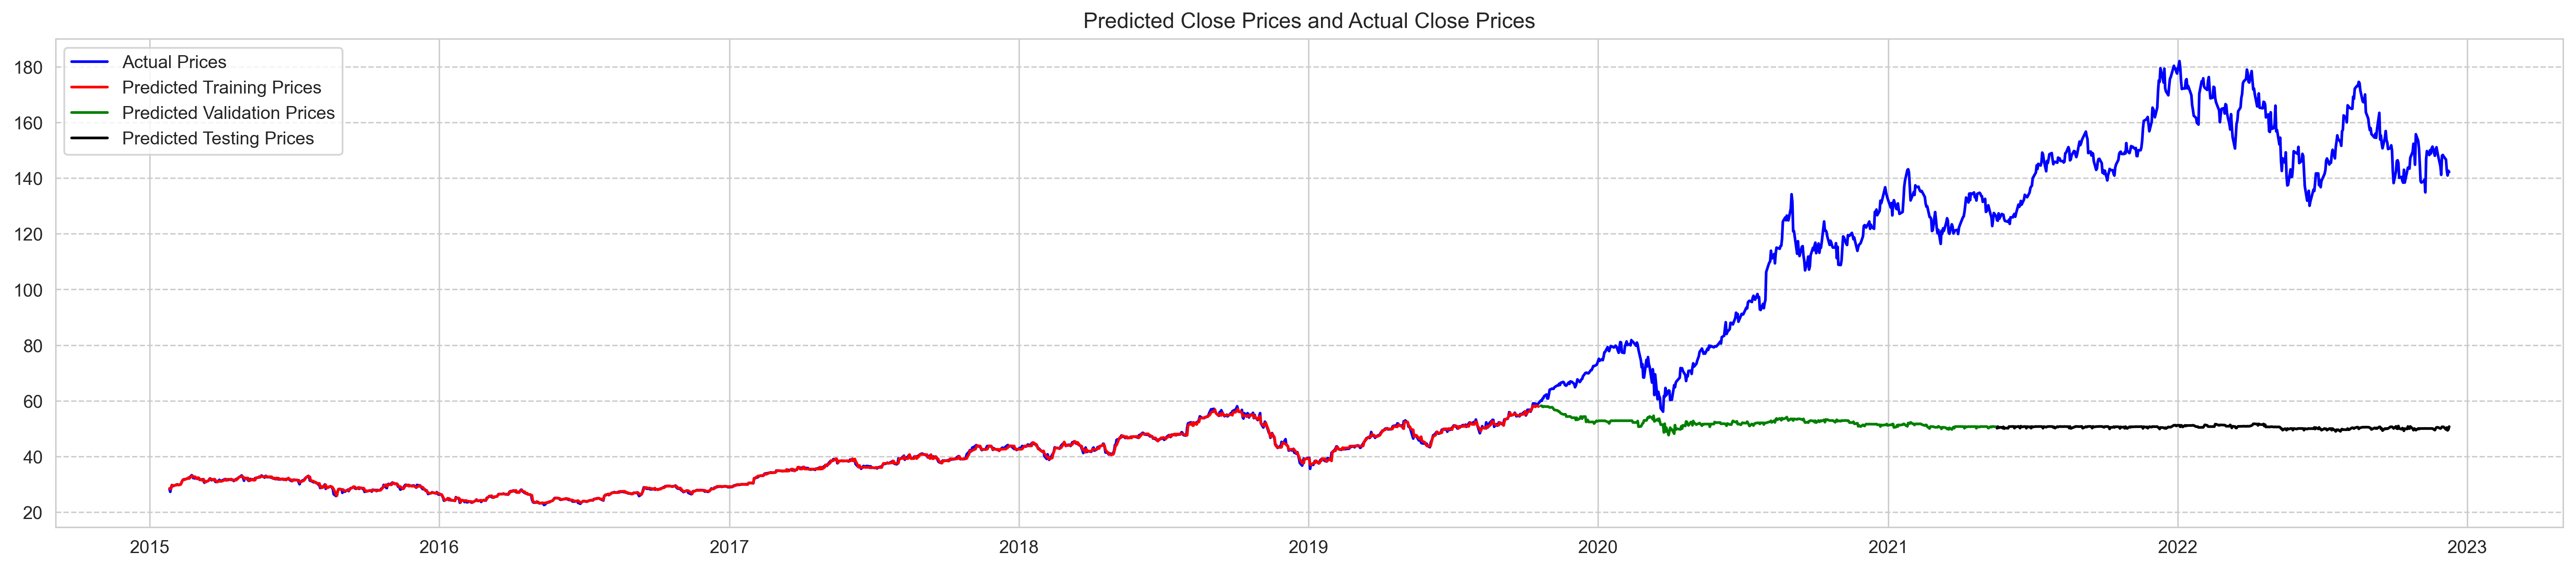

1186 396 396
1186 396 396
396
(1186, 15)
{'ae': 47.48950456002754, 'mape': inf, 'me': -0.00019549133538654604, 'mae': 0.002669449385049328, 'mpe': inf, 'rmse': 0.004314474808610202, 'corr': 0.9726313164256549, 'minmax': 0.043275732701386516}
(396, 15)
{'ae': 1875.086791409899, 'mape': 0.5922096778253978, 'me': -0.31566826573300083, 'mae': 0.3156711770050335, 'mpe': -0.592195991080784, 'rmse': 0.3563281444812275, 'corr': 0.8535581414962498, 'minmax': 0.5922095266016524}
(396, 15)
{'ae': 3806.7179100559706, 'mape': 0.7814248414064549, 'me': -0.6408616010195237, 'mae': 0.6408616010195237, 'mpe': -0.7814248414064549, 'rmse': 0.6459815434996227, 'corr': 0.9685511703090394, 'minmax': 0.7814248414064549}


In [133]:
reg = GradientBoostingRegressor(loss = 'absolute_error')
reg_list = [clone(reg) for _ in range(pred_length)]
for i in range(pred_length):
    reg_list[i].fit(x_train, y_train[:,i])
train_predictions = []
val_predictions = []
test_predictions = []
for i in range(pred_length):
    train_predictions.append(reg_list[i].predict(x_train))
    val_predictions.append(reg_list[i].predict(x_val))
    test_predictions.append(reg_list[i].predict(x_test))
train_predictions = np.transpose(train_predictions)
val_predictions = np.transpose(val_predictions)
test_predictions = np.transpose(test_predictions)

evaluate(train_predictions, y_train, val_predictions, y_val, test_predictions, y_test, AAPL_df, lookback, pred_length)

(1978,)
predict (1186,)
Train Loss: 4.4163499164609594e-10
Val Loss: 74.38041955725653
Test Loss: 130.21386456730372
predict (1186,)
val_predict (396,)
test_predict (396,)


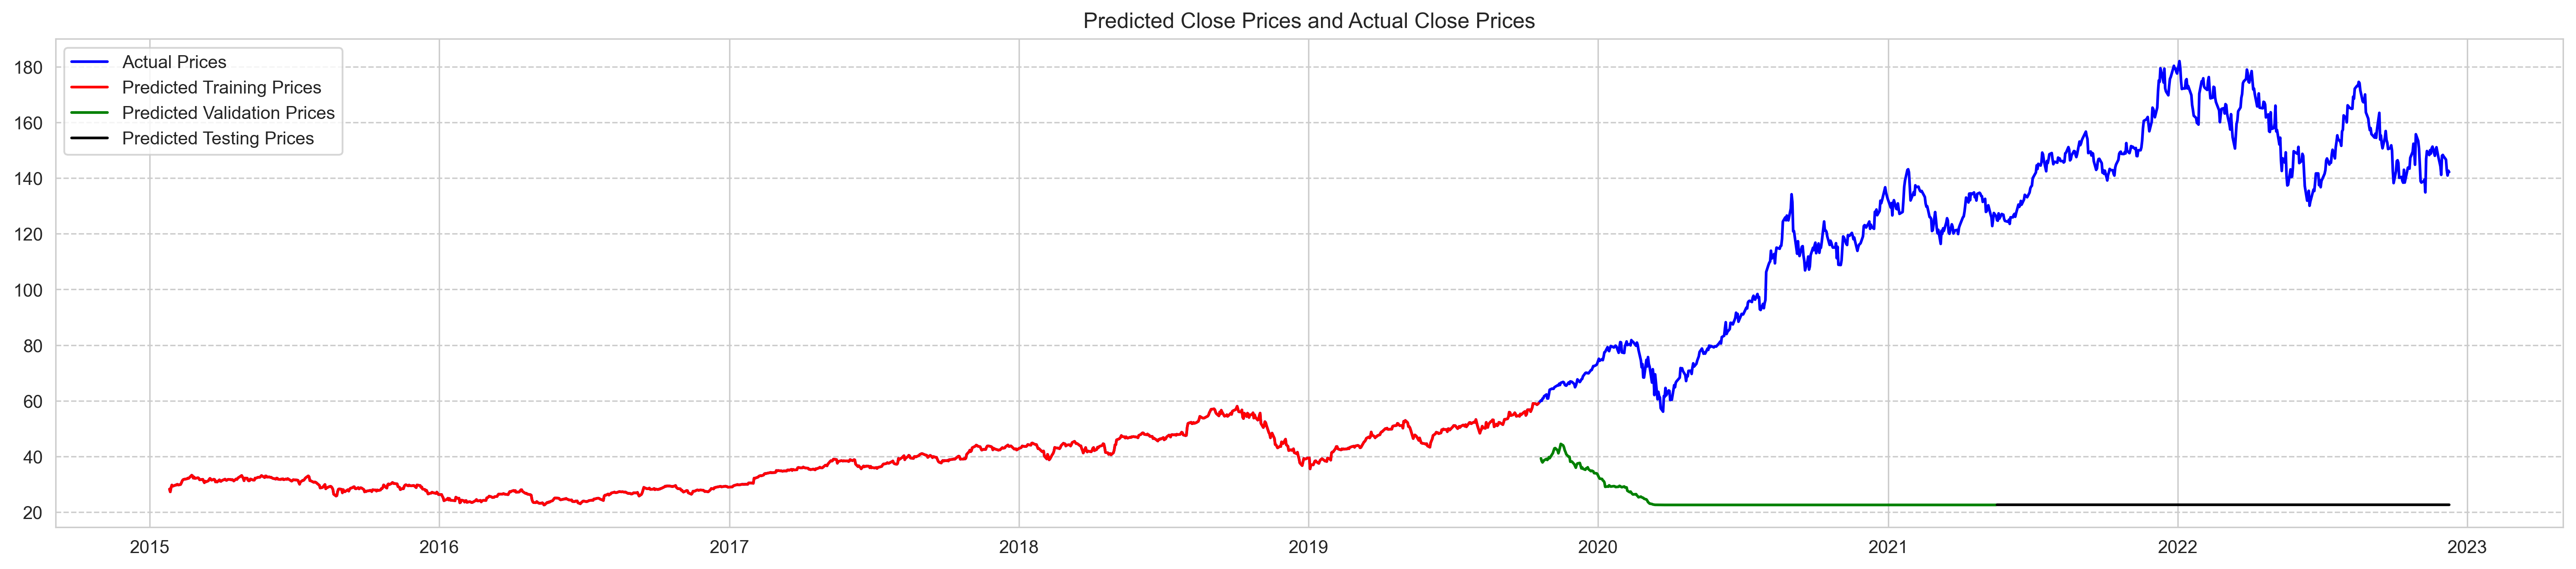

1186 396 396
1186 396 396
396
(1186, 15)
{'ae': 4.98653758347634e-08, 'mape': inf, 'me': -2.6290912041970045e-12, 'mae': 2.8030003279799548e-12, 'mpe': inf, 'rmse': 3.759087846423161e-12, 'corr': 0.8818507381911754, 'minmax': 0.000843170357570644}
(396, 15)
{'ae': 2810.7611359321036, 'mape': 0.9422666384310188, 'me': -0.47319211042628007, 'mae': 0.47319211042628007, 'mpe': -0.9422666384310188, 'rmse': 0.5073340544726238, 'corr': 0.959759513827903, 'minmax': 0.9422666384310189}
(396, 15)
{'ae': 4859.266977371376, 'mape': 0.9999999999999981, 'me': -0.8180584136988849, 'mae': 0.8180584136988849, 'mpe': -0.9999999999999981, 'rmse': 0.8222155780467321, 'corr': 0.9123015455558784, 'minmax': 0.9999999999999981}


In [136]:
from sklearn.gaussian_process import GaussianProcessRegressor
reg = GaussianProcessRegressor()
reg_list = [clone(reg) for _ in range(pred_length)]
for i in range(pred_length):
    reg_list[i].fit(x_train, y_train[:,i])
train_predictions = []
val_predictions = []
test_predictions = []
for i in range(pred_length):
    train_predictions.append(reg_list[i].predict(x_train))
    val_predictions.append(reg_list[i].predict(x_val))
    test_predictions.append(reg_list[i].predict(x_test))
train_predictions = np.transpose(train_predictions)
val_predictions = np.transpose(val_predictions)
test_predictions = np.transpose(test_predictions)

evaluate(train_predictions, y_train, val_predictions, y_val, test_predictions, y_test, AAPL_df, lookback, pred_length)

(1978,)
predict (1186,)
Train Loss: 1.3633962779181803
Val Loss: 48.50223354859787
Test Loss: 97.85073373967943
predict (1186,)
val_predict (396,)
test_predict (396,)


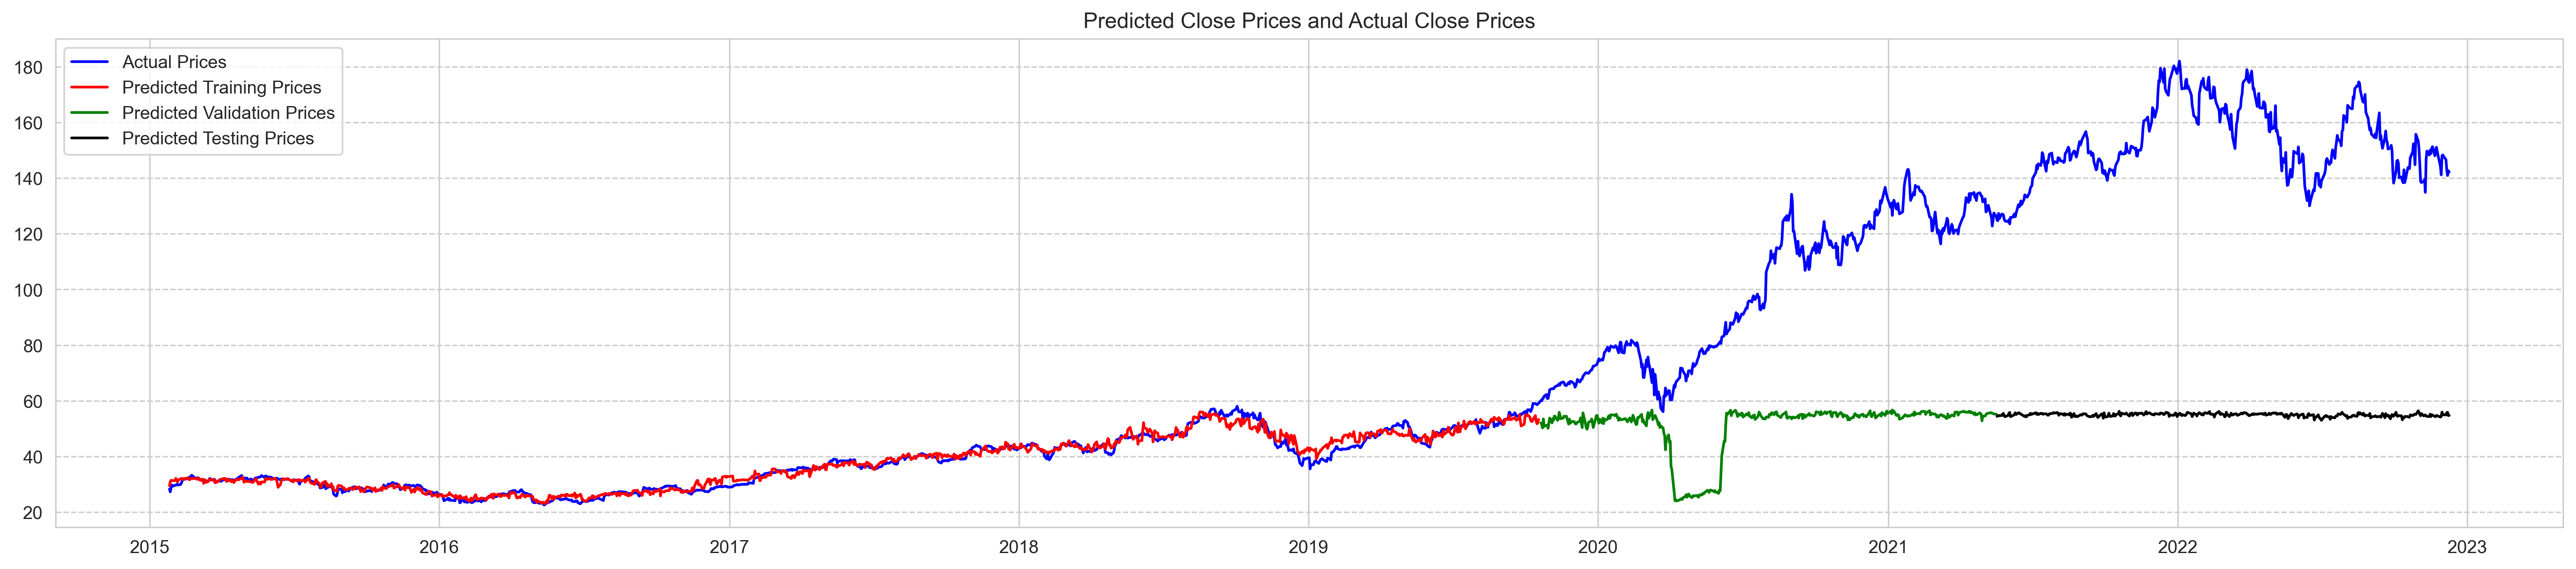

1186 396 396
1186 396 396
396
(1186, 15)
{'ae': 156.32314966539533, 'mape': inf, 'me': 0.00109964311671407, 'mae': 0.008787136012669778, 'mpe': inf, 'rmse': 0.012101083627298757, 'corr': 0.6860845287622428, 'minmax': 0.12345735252308887}
(396, 15)
{'ae': 1804.5753240680228, 'mape': 0.5885503702009558, 'me': -0.3037734831222274, 'mae': 0.30380055960741126, 'mpe': -0.5884228390714213, 'rmse': 0.33616538850157696, 'corr': 0.5716061113791231, 'minmax': 0.5885462114827429}
(396, 15)
{'ae': 3597.446307246122, 'mape': 0.7377819512838315, 'me': -0.6056306914555761, 'mae': 0.6056306914555761, 'mpe': -0.7377819512838315, 'rmse': 0.611161115583422, 'corr': 0.9605310393600738, 'minmax': 0.7377819512838315}


In [137]:
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor()
reg_list = [clone(reg) for _ in range(pred_length)]
for i in range(pred_length):
    reg_list[i].fit(x_train, y_train[:,i])
train_predictions = []
val_predictions = []
test_predictions = []
for i in range(pred_length):
    train_predictions.append(reg_list[i].predict(x_train))
    val_predictions.append(reg_list[i].predict(x_val))
    test_predictions.append(reg_list[i].predict(x_test))
train_predictions = np.transpose(train_predictions)
val_predictions = np.transpose(val_predictions)
test_predictions = np.transpose(test_predictions)

evaluate(train_predictions, y_train, val_predictions, y_val, test_predictions, y_test, AAPL_df, lookback, pred_length)

(1978,)
predict (1186,)
Train Loss: 0.5059630817632946
Val Loss: 8.815175875569208
Test Loss: 14.4248982622025
predict (1186,)
val_predict (396,)
test_predict (396,)


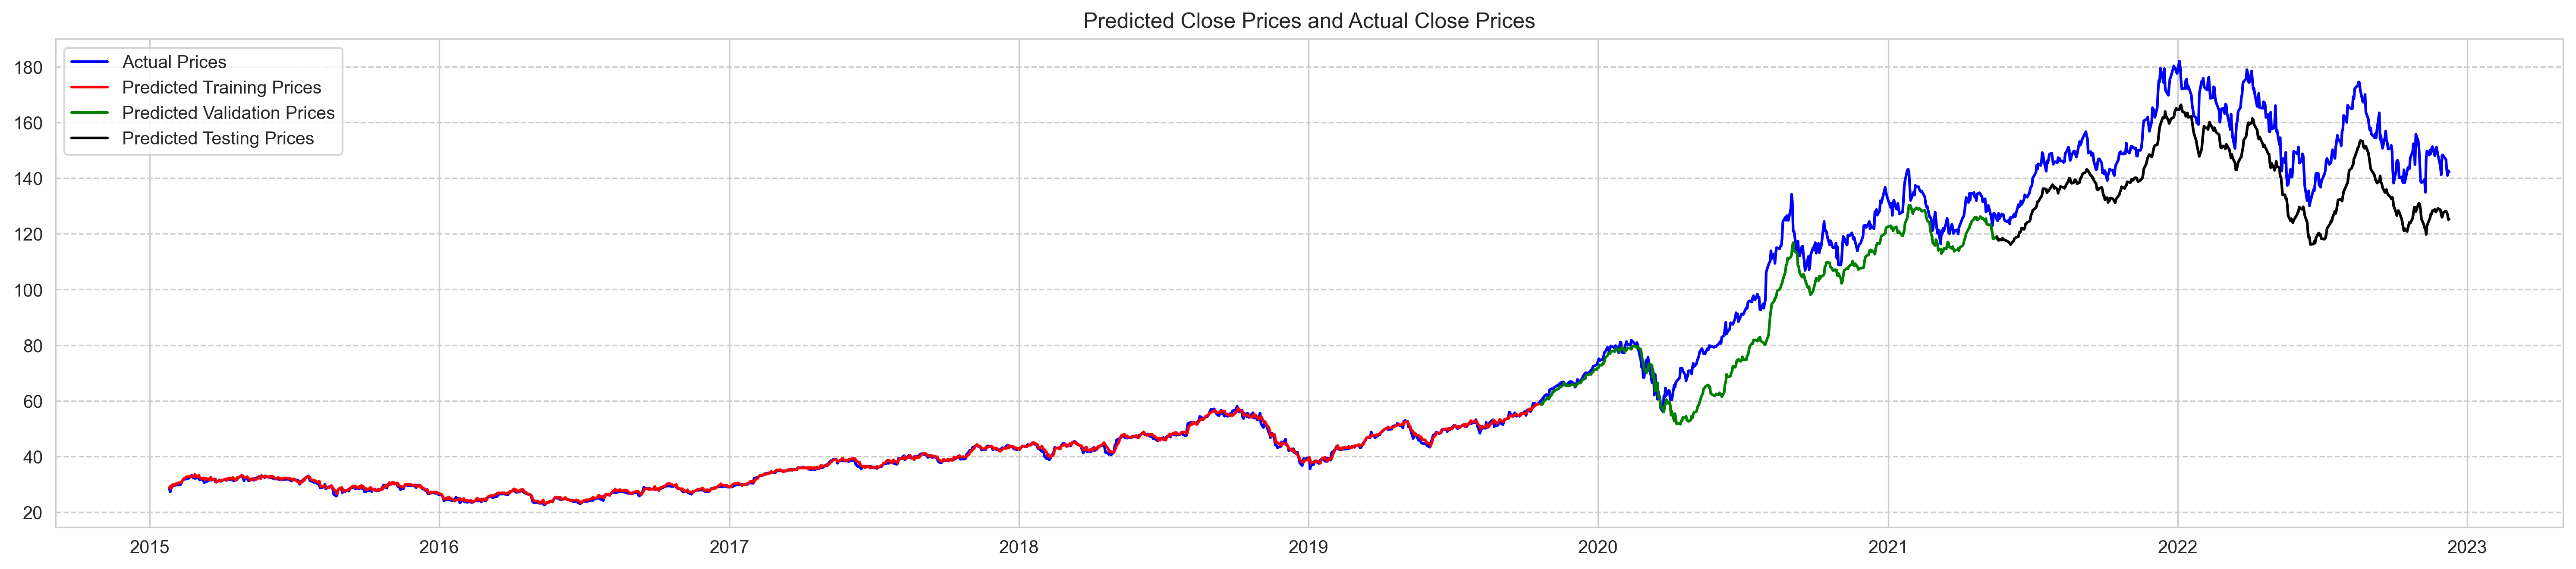

1186 396 396
1186 396 396
396
(1186, 15)
{'ae': 146.35982118590735, 'mape': inf, 'me': -0.0012525308157508382, 'mae': 0.008227083821579953, 'mpe': nan, 'rmse': 0.010882458755923936, 'corr': 0.9016823831975357, 'minmax': inf}
(396, 15)
{'ae': 1421.1613932961886, 'mape': 0.4677742334582441, 'me': -0.23765028677355568, 'mae': 0.23925275981417318, 'mpe': -0.4615138217562935, 'rmse': 0.2913385608283042, 'corr': 0.9642385036942192, 'minmax': 0.46732355789347857}
(396, 15)
{'ae': 2524.888913436852, 'mape': 0.5207685127902416, 'me': -0.42506547364256764, 'mae': 0.42506547364256764, 'mpe': -0.5207685127902416, 'rmse': 0.45481887805331117, 'corr': 0.9996284236098744, 'minmax': 0.5207685127902415}


In [138]:
from sklearn.svm import LinearSVR
reg = LinearSVR()
reg_list = [clone(reg) for _ in range(pred_length)]
for i in range(pred_length):
    reg_list[i].fit(x_train, y_train[:,i])
train_predictions = []
val_predictions = []
test_predictions = []
for i in range(pred_length):
    train_predictions.append(reg_list[i].predict(x_train))
    val_predictions.append(reg_list[i].predict(x_val))
    test_predictions.append(reg_list[i].predict(x_test))
train_predictions = np.transpose(train_predictions)
val_predictions = np.transpose(val_predictions)
test_predictions = np.transpose(test_predictions)

evaluate(train_predictions, y_train, val_predictions, y_val, test_predictions, y_test, AAPL_df, lookback, pred_length)